Los resultados necesarios son:   

**Problema Inverso**:  Tenemos que obtener la estimación de los parámetros, sin preocuparnos por nada más.  
1º Usando la PINN más básica, hacemos la estimación de varios valores de E, para varios valores de E inicial.     
2º Usando el truco de alpha, hacemos la estimación, lo mismo que antes.  
3º Usando la formulación mixta esa, hacemos lo mismo con lo anterior (con alpha si habia una diferencia sustancial).    
¿4º? Lambde?

**Problema Directo:** 
1º Sin tener que estimar ningún parámetro, sacamos las deformaciones.  
2º Sacando los parámetros sacamos las deformaciones y los valores del parámetros. 
3º Con la formulación mixta. Lo mismo.  

Importante solo imponer los tensores de tensiones conocidos alli donde hay fuerzas.

In [1]:
import os 
BASE_DIR=os.path.abspath("../../")
import sys 
sys.path.append(BASE_DIR)
DATA_DIR="/home/arturo/Documents/programacion_stuff/DeepElasticity/data/001-LinearElasticity"
from src.utils.data import Data
from src.models import PINN  
from src.train import Trainer
import torch 
import matplotlib.pyplot as plt 
import time
from datetime import datetime
import pickle


# 1. PROBLEMA INVERSO SENCILLO 

## 1.1 Test con un valor


In [7]:
data=Data("MULTIPLE_E_VALUES_NEW",10,E="0.005",base_dir=DATA_DIR)
data.load_data()
train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()


In [8]:
init_values={"nu":.4,"E":0.1}
pinn=PINN([3,80,80,80,80,80,3],use_of_alpha=False,init_values=init_values,loss_weights_init={"data":1e1,"PDE":1e5,"BC":1e6})
step_dict = {
    "step_1": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-3), 
               "epochs": 1070}
    }

In [9]:
trainer=Trainer(step_dict)

In [10]:
trainer.train(pinn,data)

Epoch:  0 loss:  65.6131820678711
Epoch:  1 loss:  48.11103057861328
Epoch:  2 loss:  45.809844970703125
Epoch:  3 loss:  45.610652923583984
Epoch:  4 loss:  44.23525619506836
Epoch:  5 loss:  42.38081359863281
Epoch:  6 loss:  40.61784744262695
Epoch:  7 loss:  39.158203125
Epoch:  8 loss:  38.075782775878906
Epoch:  9 loss:  37.314476013183594
Epoch:  10 loss:  36.73326110839844
Epoch:  11 loss:  36.21462631225586
Epoch:  12 loss:  35.71390151977539
Epoch:  13 loss:  35.23286437988281
Epoch:  14 loss:  34.78144836425781
Epoch:  15 loss:  34.36521911621094
Epoch:  16 loss:  33.988826751708984
Epoch:  17 loss:  33.65835952758789
Epoch:  18 loss:  33.378597259521484
Epoch:  19 loss:  33.14970016479492
Epoch:  20 loss:  32.9665412902832
Epoch:  21 loss:  32.820777893066406
Epoch:  22 loss:  32.70360565185547
Epoch:  23 loss:  32.607696533203125
Epoch:  24 loss:  32.52783966064453
Epoch:  25 loss:  32.46046829223633
Epoch:  26 loss:  32.40287399291992
Epoch:  27 loss:  32.35255432128906
E

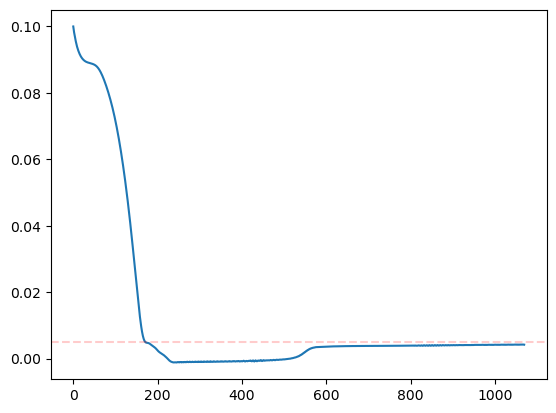

In [13]:
plt.plot(pinn.params_history["E"])
plt.axhline(y=0.005,linestyle="--",alpha=0.2,color="red")

In [19]:
from pympler import asizeof
asizeof.asizeof(pinn)/1e+6


0.204712

## 1.2 Caso para todos los valores de E disponibles:   

In [6]:

EPOCHS1=200
EPOCHS2=1600
EPOCHS3=1200
fecha_actual_str = datetime.now().strftime("%Y-%m-%d")

RESULTADOS_DIR=os.path.join(BASE_DIR,"informes/endYear2023/resultados")

DAILY_RESULTADOS_DIR=os.path.join(RESULTADOS_DIR,fecha_actual_str)
os.makedirs(DAILY_RESULTADOS_DIR,exist_ok=True)

E_options=["0.020","0.040","0.050","0.060","0.005","0.009"]#"0.020",
E_inits=[0.01,0.07,0.1,0.3,1]
loss_weights_init={"data":1e1,"PDE":1e5,"BC":1e6}
pinn_arch=[3,80,80,80,80,80,3]

historial_E_train={}
for i,E_real_str in enumerate(E_options):
    print(f"E_real: {E_real_str}")
    data=Data("MULTIPLE_E_VALUES",10,E=E_real_str,base_dir=DATA_DIR)
    data.load_data()
    train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()
    dict_E_inits={}
    for E_init in E_inits:
        print(f"\t E_init: {E_init}")

        time_init=time.time()
        init_values={"nu":.4,"E":E_init}
        pinn=PINN(pinn_arch,use_of_alpha=False,init_values=init_values,loss_weights_init=loss_weights_init)
        step_dict = {
            "step_1": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-2), 
                    "epochs": EPOCHS1},
            "step_2": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-3), 
                    "epochs": EPOCHS2},
            "step_3": {"optim": torch.optim.Adam(pinn.parameters(), lr=1e-4), 
                    "epochs": EPOCHS3}
            }
        trainer=Trainer(step_dict)
        trainer.train(pinn,data)
        time_fin=time.time()
        dict_E_inits[str(E_init)]={"model_object":pinn,"time":time_fin-time_init,"E_real":float(E_real_str)}
    historial_E_train[E_real_str]=dict_E_inits
    del dict_E_inits
    #guardamos 
    fecha_hora_actual_str = datetime.now().strftime("%Y-%m-%dT%H-%M-%S")
    archivo_pickle=os.path.join(DAILY_RESULTADOS_DIR, f'{fecha_hora_actual_str}.pkl')
    with open(archivo_pickle, 'wb') as archivo:
        pickle.dump(historial_E_train, archivo)



E_real: 0.020
	 E_init: 0.01
step_1
Epoch:  1 loss:  13.744867324829102
Epoch:  2 loss:  19.15102767944336
Epoch:  3 loss:  15.887118339538574
Epoch:  4 loss:  11.558156967163086
Epoch:  5 loss:  10.213290214538574
Epoch:  6 loss:  12.023263931274414
Epoch:  7 loss:  10.702495574951172
Epoch:  8 loss:  9.497615814208984
Epoch:  9 loss:  9.358161926269531
Epoch:  10 loss:  9.552430152893066
Epoch:  11 loss:  9.432206153869629
Epoch:  12 loss:  9.251237869262695
Epoch:  13 loss:  8.375667572021484
Epoch:  14 loss:  9.001489639282227
Epoch:  15 loss:  8.562738418579102
Epoch:  16 loss:  8.713648796081543
Epoch:  17 loss:  8.448917388916016
Epoch:  18 loss:  8.16269302368164
Epoch:  19 loss:  8.410877227783203
Epoch:  20 loss:  8.197433471679688
Epoch:  21 loss:  8.095466613769531
Epoch:  22 loss:  8.084867477416992
Epoch:  23 loss:  7.921924114227295
Epoch:  24 loss:  7.896690368652344
Epoch:  25 loss:  7.916803359985352
Epoch:  26 loss:  7.696495056152344
Epoch:  27 loss:  7.808659553527

In [7]:
historial_E_train

{'0.020': {'0.01': {'model_object': PINN(
     (activation): Tanh()
     (linears): ModuleList(
       (0): Linear(in_features=3, out_features=80, bias=True)
       (1-4): 4 x Linear(in_features=80, out_features=80, bias=True)
       (5): Linear(in_features=80, out_features=3, bias=True)
     )
     (loss_function): MSELoss()
   ),
   'time': 710.0814728736877,
   'E_real': 0.02},
  '0.07': {'model_object': PINN(
     (activation): Tanh()
     (linears): ModuleList(
       (0): Linear(in_features=3, out_features=80, bias=True)
       (1-4): 4 x Linear(in_features=80, out_features=80, bias=True)
       (5): Linear(in_features=80, out_features=3, bias=True)
     )
     (loss_function): MSELoss()
   ),
   'time': 717.1610901355743,
   'E_real': 0.02},
  '0.1': {'model_object': PINN(
     (activation): Tanh()
     (linears): ModuleList(
       (0): Linear(in_features=3, out_features=80, bias=True)
       (1-4): 4 x Linear(in_features=80, out_features=80, bias=True)
       (5): Linear(in_fe

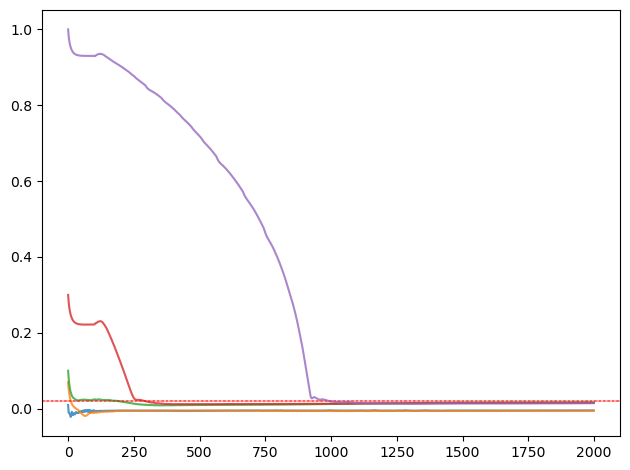

In [16]:
plt.style.use('default')


fig,ax=plt.subplots()

x1, x2, y1, y2 = -1, 1400, 0, 0.05  # subregion of the original image
# axins = ax.inset_axes(
# [0.3, 0.3, 0.67, 0.67],
# xlim=(x1, x2), ylim=(y1, y2), )

E_real_str="0.020"
dict_E_real=historial_E_train[E_real_str]

for E_init in dict_E_real.keys():
    init_dict=dict_E_real[E_init]
    valores_E_train=init_dict["model_object"].params_history["E"]
    ax.plot(valores_E_train,alpha=0.79,label=f"Init E value: {i}")
    ax.axhline(init_dict["E_real"],linestyle="-.",alpha=0.8,color="red",linewidth=0.3)
    #axins.plot(valores_E_train)
    #axins.axhline(init_dict["E_real"],linestyle="-.",alpha=0.7,color="red",linewidth=1)

#plt.title(f"E_true:{E_real_str}")
#ax.indicate_inset_zoom(axins, edgecolor="black")
plt.tight_layout()


In [ ]:
for E_init in dict_E_real.keys():
    init_dict=dict_E_real[E_init]
    valores_E_train=init_dict["model_object"].params_history["E"]
    print()

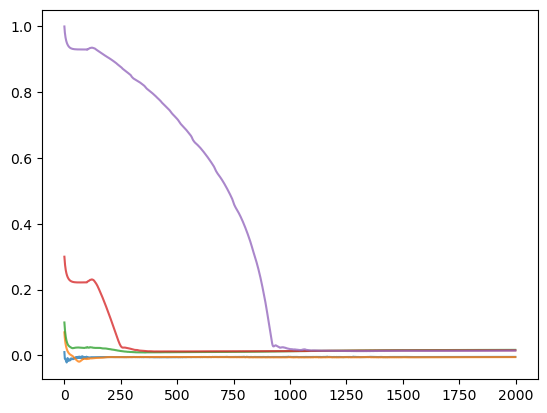

In [10]:
plt.style.use('default')


fig,ax=plt.subplots()

E_real_str="0.020"
dict_E_real=historial_E_train[E_real_str]

for E_init in dict_E_real.keys():
    init_dict=dict_E_real[E_init]
    valores_E_train=init_dict["model_object"].params_history["E"]
    ax.plot(valores_E_train,alpha=0.79,label=f"Init E value: {i}")

## 1.3 Lo mismo pero haciendo estimaciones de E con alpha 

## 1.4 Lo mismo pero dejando los pesos de cada término como un parametro de la red 

# 2 Estimación de desplazamientos u

## 2.1 Estimación de desplazamientos conocidos los parametros

## 2.2 Sin conocer los parámetros  

Esto es exactamente lo mismo que cuando estimamos E, pero ahora estamos analizando los datos de desplazamiento tbn.

# 3 Forma Mixta: Modelo output u y sigma  
Importante, que los sigma que se imponen y comprueban, son solo los de la zona donde se aplica la fuerza. Entonces, tenemos, que para la parte PDE todo igual con u,v,w, además que ahora imponemos la eq. const con el nuevo output. Y luego con los BC igual, solo los aplicamos sobre puntos fijos, y los sigma calculados con u,v,w sobre los de la zona de presión. Pero ahora, al calcular la loss de la data, tenemos que calcular sobre muchos puntos la de desplazamientos, pero solo sobre unos pocos (los de ls BC), la sigma.



## 3.1 Estimación simple de E, o con alpha, lo que sea.  
Además si ha ido bien con los pesos variables, que no creo, pues lo añadimos también.  
Exploramos los desplazamientos además de E. 